# Saliency Maps for Visualization of ResNet50 Architecture

A saliency map is a visual explanation of a neural network's prediction. It shows which parts of the input image were most influential for the network in making its prediction. This can be useful for understanding how a neural network works and for identifying potential problems or errors in its predictions. This approach is based on the idea that the network is looking for certain patterns in the input image, and the saliency map shows which parts of the image contain those patterns.

Saliency maps use a technique called backpropagation to compute the gradient of the target class with respect to the input image, which gives a measure of how sensitive the model's prediction is to changes in each pixel of the input. This gradient is then used to generate a heatmap highlighting the most important regions of the image.

To create a saliency map for ResNet50, we would first feed an input image into the network and record the network's prediction. Then, we would compute the gradient of the network's prediction with respect to the input image. This gradient tells us how much the prediction changes when we make small changes to the input image. By visualizing the gradient, we can see which parts of the input image had the greatest influence on the network's prediction.

Saliency maps are useful because they can help us understand how a neural network works and why it makes the predictions it does. They can also help us identify potential errors or problems in the network's behavior. For example, if the saliency map shows that the network is only paying attention to a small part of the input image, it could indicate that the network is not considering all of the relevant information when making its prediction.


Sources:

[1] https://arxiv.org/abs/1312.6034

[2] https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4


#### Importing required Libraries

In [17]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import cv2
import os
import matplotlib.pyplot as plt
import tqdm
from PIL import Image

#### Loading the Model and Dataset

In [200]:
# Load the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
model = model.to(device)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6).to(device)

state_dict = torch.load(os.path.join('model','landscape_resnet.pt'), map_location=torch.device(device))

# Load the weights into the network
model.load_state_dict(state_dict)

for param in model.parameters():
    param.requires_grad_(False)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [146]:
# load test dataset
X_test = torch.load(os.path.join('data', 'X_test.pt'))
print(X_test.shape)

y_test = torch.load(os.path.join('data', 'y_test.pt'))
print(y_test.shape)

(2993, 150, 150, 3)
(2993,)


#### Preprocessing 

In [193]:
#process the image
def preprocess(img):
    image = Image.fromarray(img)
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773])
    ])
    
    image = preprocess(image)
    image_tensor = torch.unsqueeze(image, 0)
    
    return image_tensor

In [194]:
#get label text based on class 
def decode_label(ind):
    
    label_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
    decode_dict = {v: k for k, v in label_dict.items()}
    
    return decode_dict[ind]

#### Computing the Saliency Map

In [195]:
## Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)

def output_retrieval(model, image, label):
    
    image = preprocess(image)
    # Set the device for the image
    image = image.to(device)
    # Set the requires_grad_ to the image for retrieving gradients
    image.requires_grad_()

    #Retrieve output from the image
    output = model(image)

    # Catch the output
    output_idx = output.argmax()
    output_max = output[0, output_idx]

    # Do backpropagation to get the derivative of the output based on the image
    output_max.backward()
    
    #get the saliency score
    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency = saliency.reshape(224, 224)
    
    return saliency
        

In [196]:
#get the prediction based on the ouput processed through the model
def prediction(model, image):
    image = preprocess(image)
    image = image.to(device)
    #Retrieve output from the image
    output = model(image)
    prediction = output.argmax(dim=1)
    prediction = int(prediction[0].cpu().numpy())
    
    return prediction

#### Visualizations

In [197]:
#generate the saliency map, and plot the image and the saliency map
def saliency_map(output, image, label):
    
    saliency = output_retrieval(model, image, label)

    # Reshape the image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    label = label

    predict = prediction(model, image)

    # Visualize the image and the saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].set_title(f"Label: {decode_label(label)}, Prediction: {decode_label(predict)}")
    ax[0].axis('off')

    ax[1].imshow(saliency.cpu(), cmap='jet')
    ax[1].axis('off')

    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()

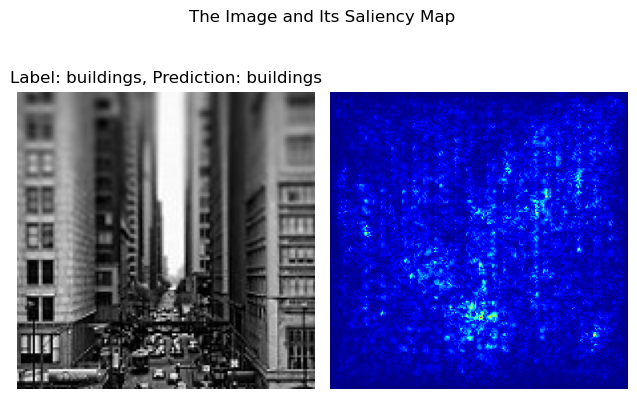

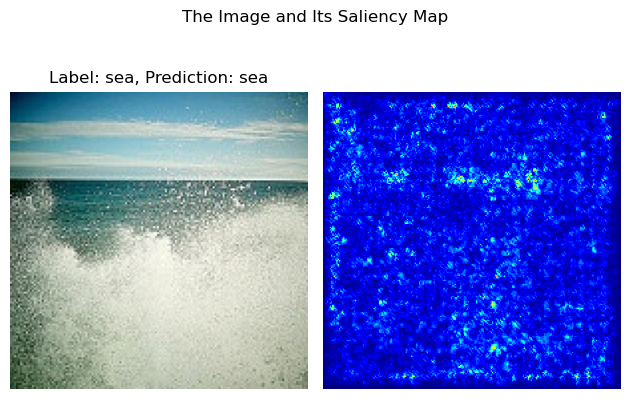

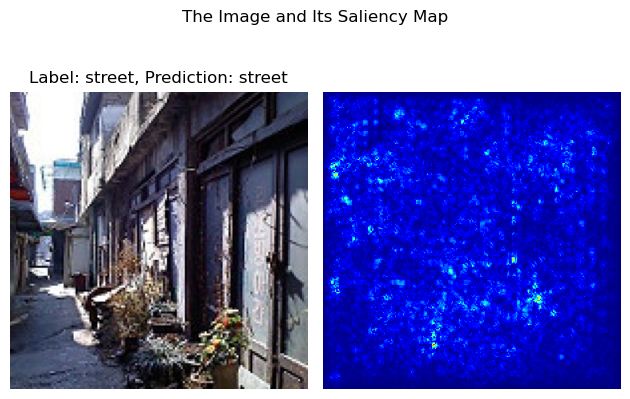

In [198]:
#correct predictions
saliency_map(model, X_test[89], y_test[89])
saliency_map(model, X_test[2000], y_test[2000])
saliency_map(model, X_test[2505], y_test[2505])

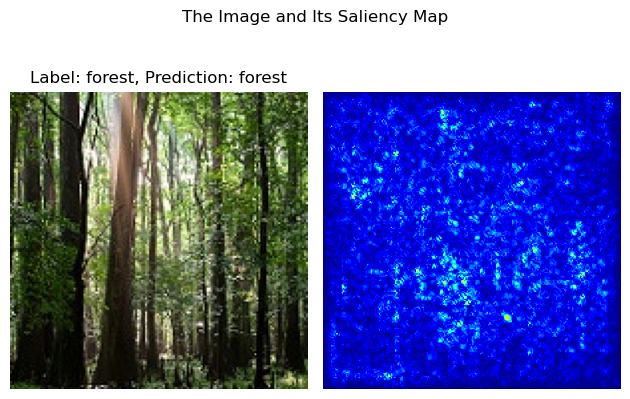

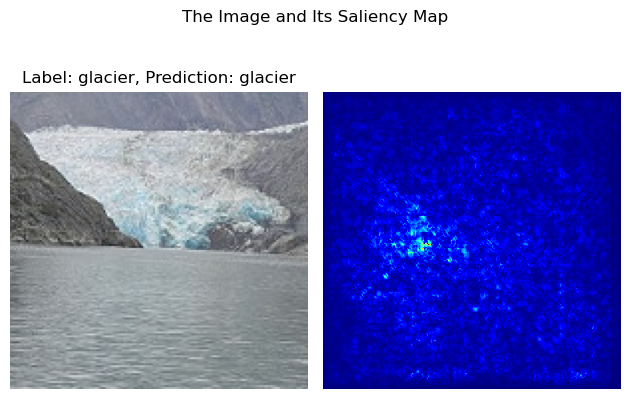

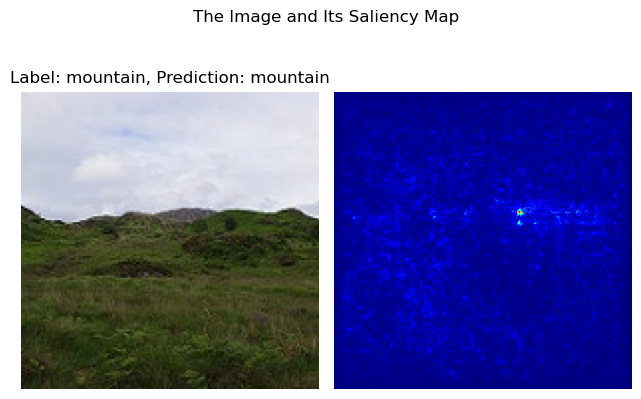

In [201]:
#correct predictions
saliency_map(model, X_test[477], y_test[477])
saliency_map(model, X_test[950], y_test[950])
saliency_map(model, X_test[1479], y_test[1479])


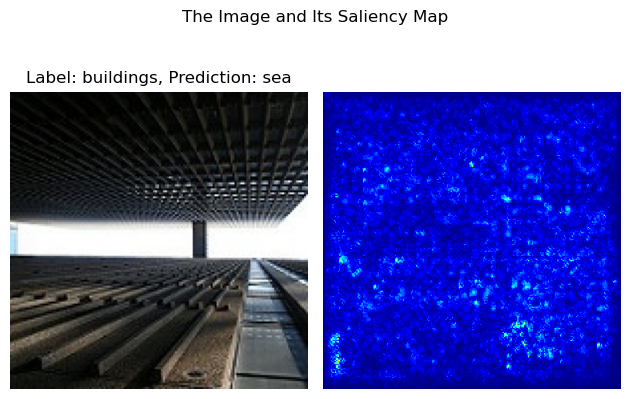

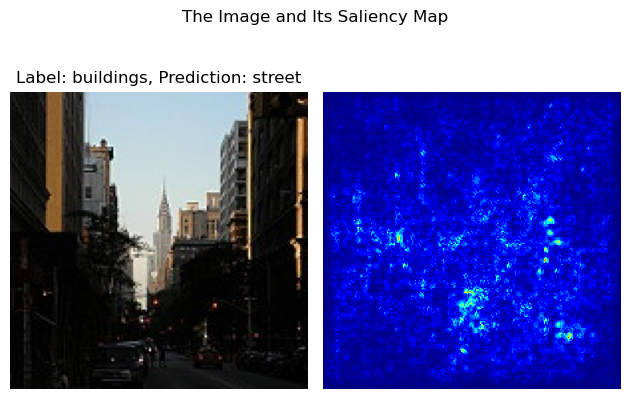

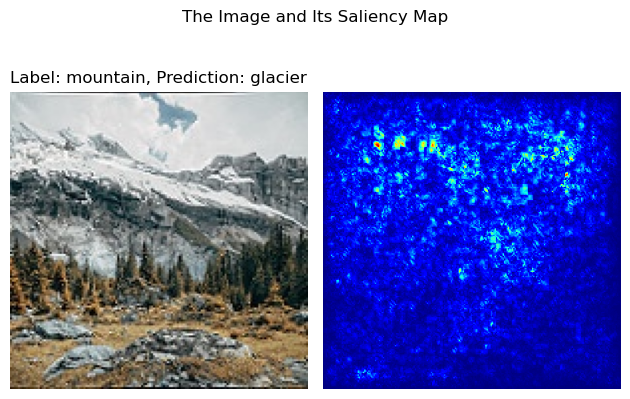

In [199]:
#false predictions
saliency_map(model, X_test[30], y_test[30])
saliency_map(model, X_test[86], y_test[86])
saliency_map(model, X_test[1518], y_test[1518])


It's important to note that saliency maps are only one tool for understanding and explaining a neural network's behavior. There are many other approaches and techniques that can be used for this purpose, and no single method is perfect in all cases. We have explored some other approaches for the ResNet50 architecture, explained in the respective Notebooks